<class 'pandas.core.frame.DataFrame'>
Index: 1948 entries, 0 to 4806
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   budget                1948 non-null   int64  
 1   popularity            1948 non-null   float64
 2   production_companies  1948 non-null   object 
 3   production_countries  1948 non-null   object 
 4   revenue               1948 non-null   int64  
 5   runtime               1948 non-null   float64
 6   vote_average          1948 non-null   float64
 7   vote_count            1948 non-null   int64  
 8   genres_names          1948 non-null   object 
 9   keywords_names        1948 non-null   object 
 10  cast_names            1948 non-null   object 
 11  release_year          1948 non-null   float64
 12  is_modern_period      1948 non-null   int64  
 13  year_based_trend      1948 non-null   int64  
dtypes: float64(4), int64(5), object(5)
memory usage: 228.3+ KB


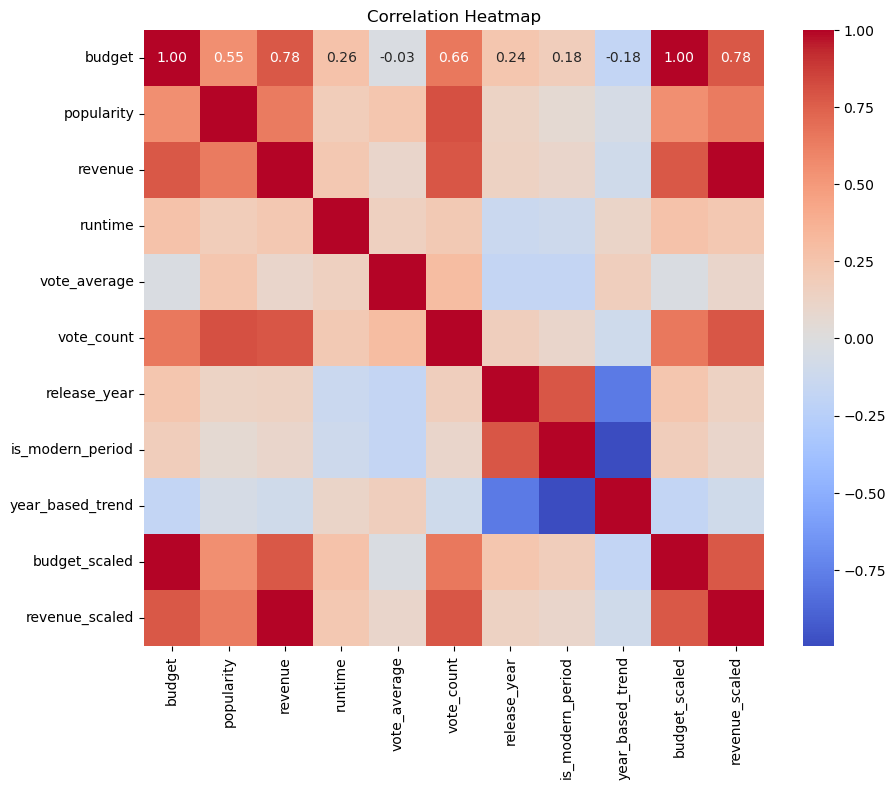

MAE: 0.3067604404708234
MSE: 0.13409190265228677
MAE: 0.29983846153846155
MSE: 0.13595595128205124


In [7]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
credits = pd.read_csv('../tmdb_5000_credits.csv')
movies = pd.read_csv('../tmdb_5000_movies.csv') 
movies = movies.drop(columns=['homepage'])
credits = credits[['title','cast', 'crew']]
movies = movies.merge(credits, on='title')

import json
import pandas as pd

def extract_keys(column_data):
    unique_keys = set()
    for entry in column_data:
        if pd.isnull(entry):  # Null 값 있으면 패스. 어차피 상관없음.
            continue
        try:
            data = json.loads(entry) if isinstance(entry, str) else entry
            for item in data:
                unique_keys.update(item.keys())
        except (json.JSONDecodeError, TypeError):
            continue
    return unique_keys

def extract_column_values(column_data, key):
    extracted_values = []
    for entry in column_data:
        if pd.isnull(entry):  # Null값 제외. 
            extracted_values.append(None)
            continue
        try:
            data = json.loads(entry) if isinstance(entry, str) else entry
            values = [item[key] for item in data if key in item]
            extracted_values.append(', '.join(values))  # Join values with a comma
        except (json.JSONDecodeError, TypeError):
            extracted_values.append(None)
    return extracted_values

movies['genres_names'] = extract_column_values(movies['genres'], 'name')

movies['keywords_names'] = extract_column_values(movies['keywords'], 'name')

movies['cast_names'] = extract_column_values(movies['cast'], 'name')

import pandas as pd
import matplotlib.pyplot as plt

# 출시 연도 추출
movies['release_year'] = pd.to_datetime(movies['release_date'], errors='coerce').dt.year

# 연도별 평균 평점 계산
yearly_rating = movies.groupby('release_year')['vote_average'].mean().reset_index()

movies['is_modern_period'] = movies['release_year'].apply(lambda x: 1 if 1980 <= x <= 2016 else 0)

# 연도별 평점의 변화율을 반영하는 변수 추가
movies['year_based_trend'] = movies['release_year'].apply(
    lambda x: -1 if 1980 <= x <= 2016 else (1 if x > 2016 else 0)
)

movies = movies.dropna(subset=['overview', 'release_date', 'runtime', 'release_year'])

movies_filtered = movies[movies['vote_average'] >= 6.5].copy()

movie = movies_filtered.drop(
    columns=[
        'id', 'genres', 'keywords', 'original_language', 'original_title',
        'overview', 'release_date', 'spoken_languages', 'status', 'tagline',
        'title', 'cast', 'crew'
    ]
)

movie.info()

from sklearn.preprocessing import MinMaxScaler

# budget, revenue 정규화
scaler = MinMaxScaler()
movie[['budget_scaled', 'revenue_scaled']] = scaler.fit_transform(movie[['budget', 'revenue']])

# 숫자형 열만 선택
numeric_movie = movie.select_dtypes(include=['float64', 'int64'])

# 상관관계 계산
correlation = numeric_movie.corr()

# 상관관계 히트맵 시각화
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Heatmap')
plt.show()

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 숫자형 변수만 선택
features = ['budget_scaled', 'revenue_scaled', 'popularity', 'runtime', 'vote_count']

train_len = len(movie) * 0.8
df_train = movie.loc[:len(movie) * 0.8]
df_test = movie.loc[train_len:]



X_train = df_train[features]
y_train = df_train['vote_average']
X_test = df_test[features]
y_test = df_test['vote_average']

# # 데이터 분리
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
import ast
# 훈련 데이터만 쓰도록 수정 필요 


# 장르별로 평점을 계산하기 위해 'genres' 열을 파싱
def parse_genres(genres):
    try:
        genres_list = ast.literal_eval(genres)
        return [genre['name'] for genre in genres_list]
    except:
        return []

# .loc를 사용하여 genres_list 열 생성
movies_filtered.loc[:, 'genres_list'] = movies_filtered['genres'].apply(parse_genres)

# 각 장르별 평균 평점 계산
from collections import defaultdict

genre_rating = defaultdict(list)
for _, row in movies_filtered.iterrows():
    for genre in row['genres_list']:
        genre_rating[genre].append(row['vote_average'])

# 장르별 평균 평점 계산
average_genre_rating = {genre: sum(ratings)/len(ratings) for genre, ratings in genre_rating.items()}
sorted_genre_rating = sorted(average_genre_rating.items(), key=lambda x: x[1], reverse=True)

# 결과 확인
print(sorted_genre_rating)